In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse

plt.switch_backend('agg')
# In[3]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:

from synthetic_dataloader import *


from synthetic_utils import *


# In[5]:


from trainer_dataloader import *
from networks import *
from losses import *


# In[6]:

In [3]:

input_size = 96
batch_size = 64
num_workers = 4


cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))


# In[8]:


data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
}



Device set: cuda


In [4]:
# if independent:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
# else:
DATA_PATH = '/home/s1791387/diss/dependent_gen/'
print(DATA_PATH)
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

/home/s1791387/diss/dependent_gen/


In [5]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [6]:
LOAD_PATH = './eo2_nosig_dep/1/weights/encoder_106_0.77.pth'

In [7]:
laftr_encoder = torch.load(LOAD_PATH)

In [8]:
gender_train = ShapeDataset(train_df)
gender_valid = ShapeDataset(val_df)
gender_test = ShapeDataset(test_df)

In [9]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
advtest_loader = DataLoader(gender_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [10]:
classifier = ClassNet()

adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [11]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                classifier, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, classifier,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.169 (2.169)	Loss 2.3784 (2.3784)	Accuracy 0.4062 (0.4062)
Batch: [10/79]	Time 0.065 (0.459)	Loss 0.6188 (0.9203)	Accuracy 0.5781 (0.5128)
Batch: [20/79]	Time 1.312 (0.449)	Loss 0.6393 (0.7785)	Accuracy 0.4688 (0.5193)
Batch: [30/79]	Time 0.076 (0.407)	Loss 0.6281 (0.7283)	Accuracy 0.4688 (0.5116)
Batch: [40/79]	Time 1.286 (0.414)	Loss 0.6598 (0.6992)	Accuracy 0.5625 (0.5122)
Batch: [50/79]	Time 0.123 (0.395)	Loss 0.5971 (0.6796)	Accuracy 0.6719 (0.5484)
Batch: [60/79]	Time 1.310 (0.401)	Loss 0.5997 (0.6580)	Accuracy 0.6406 (0.5830)
Batch: [70/79]	Time 0.087 (0.389)	Loss 0.5531 (0.6466)	Accuracy 0.7344 (0.6072)
----------


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Avg validation loss: 0.5711563196182251 	 Accuracy: 0.746
--------------------
Epoch 0/20	Time 33.646 sec (33.646 sec)
--------------------
Epoch: 1/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.080 (2.080)	Loss 0.4931 (0.4931)	Accuracy 0.7344 (0.7344)
Batch: [10/79]	Time 0.069 (0.468)	Loss 0.5080 (0.5902)	Accuracy 0.7500 (0.7116)
Batch: [20/79]	Time 1.340 (0.456)	Loss 0.6116 (0.5726)	Accuracy 0.7812 (0.7344)
Batch: [30/79]	Time 0.053 (0.404)	Loss 0.6231 (0.5747)	Accuracy 0.6562 (0.7308)
Batch: [40/79]	Time 1.399 (0.412)	Loss 0.4674 (0.5706)	Accuracy 0.7969 (0.7317)
Batch: [50/79]	Time 0.035 (0.393)	Loss 0.5309 (0.5645)	Accuracy 0.7344 (0.7390)
Batch: [60/79]	Time 1.378 (0.399)	Loss 0.5500 (0.5668)	Accuracy 0.7188 (0.7349)
Batch: [70/79]	Time 0.027 (0.386)	Loss 0.6416 (0.5647)	Accuracy 0.6719 (0.7364)
----------
Avg validation loss: 0.5722880353927612 	 Accuracy: 0.75
--------------------
Epoch 1/20	Time 33.197 sec (33.422 sec)
--------------------
Epoch: 2/20
Batch: [0/79]	Time 1.984 (1.984)	Loss 0.4703 (0.4703)	Accuracy 0.8594 (0.8594)
Batch: [10/79]	Time 0.071 (0.464)	Loss 0.5194 (0.5176)	Accuracy 0.7500 (0.7656)
Batch: [20/79]	Time 1.320 (0.449)	Loss 0

No handles with labels found to put in legend.


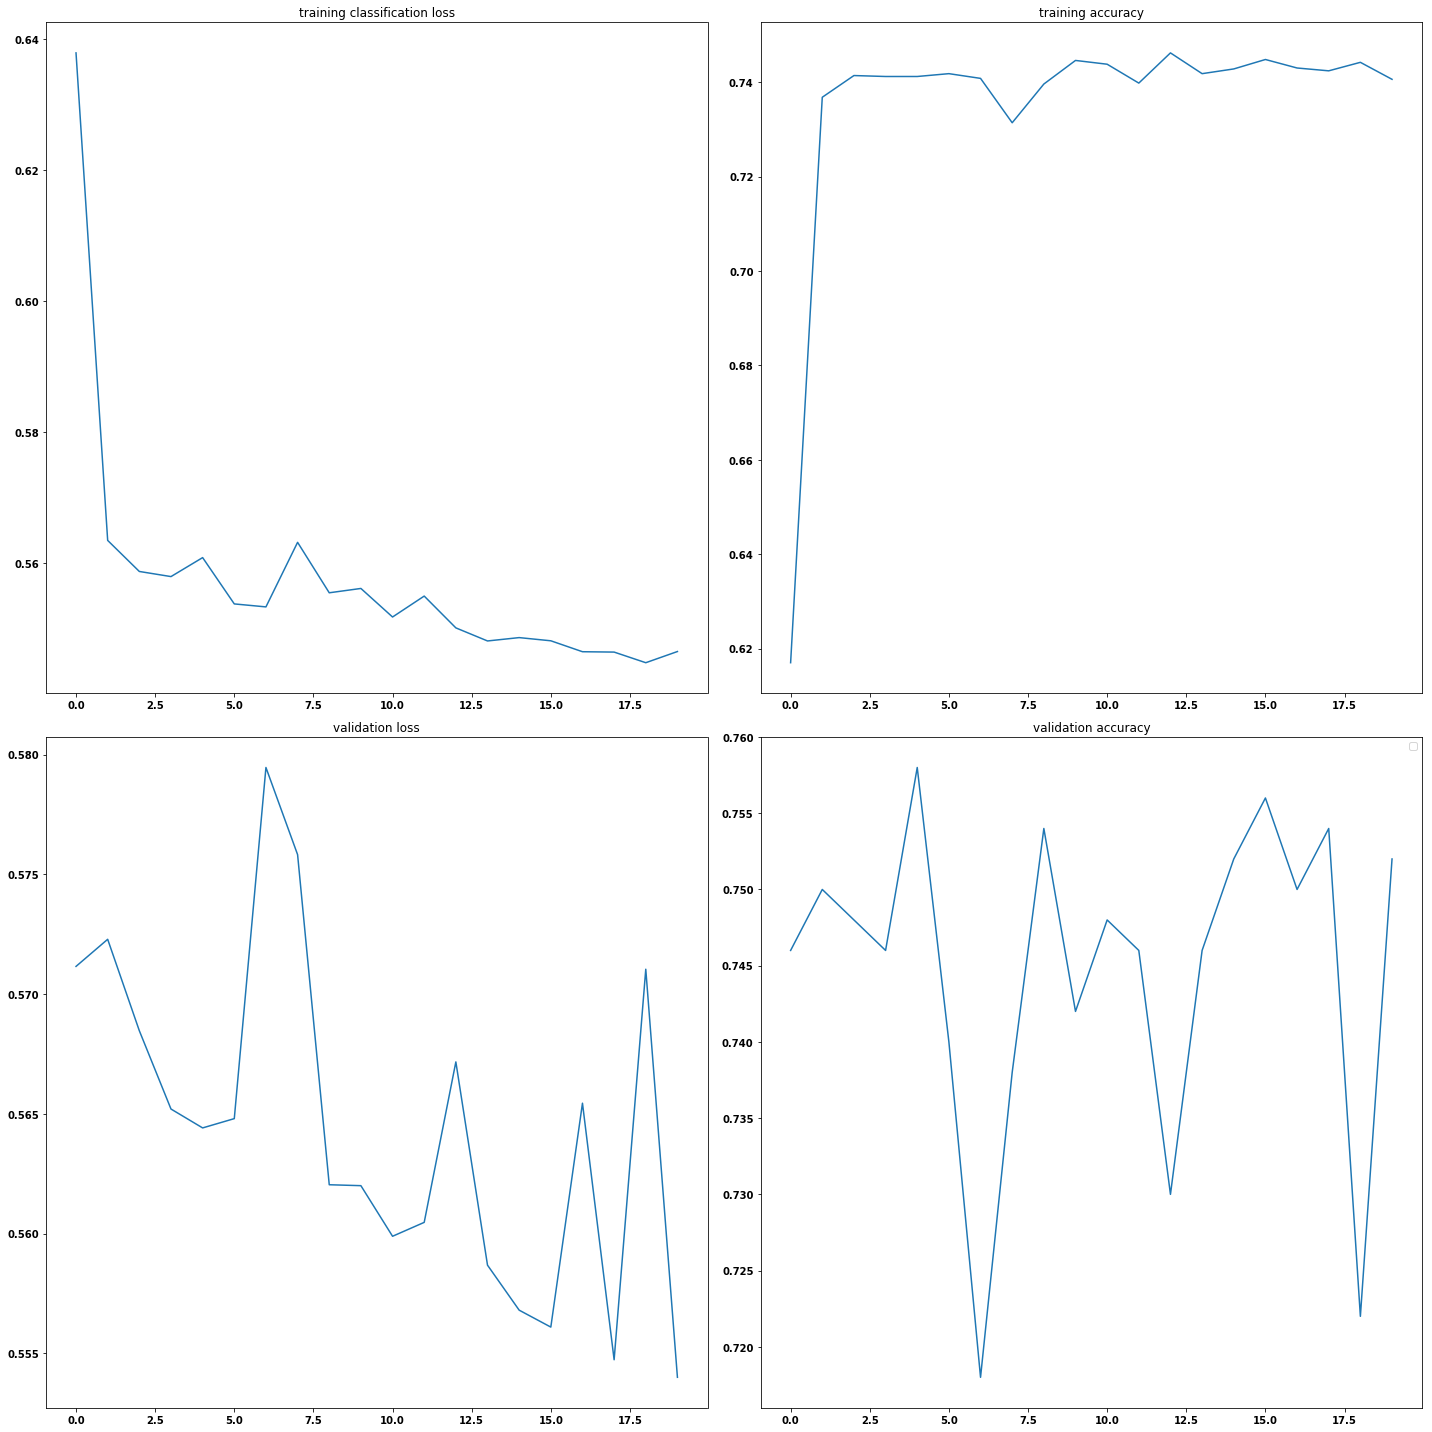

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)
plt.legend()
plt.tight_layout()

In [13]:
test_loss, test_acc = validate_classifier_epoch(advtest_loader, laftr_encoder, classifier,
                                 adv_criterion, device)

/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [14]:
test_loss, test_acc

(0.5794516201019287, 0.708)